In [2]:
import fsspec
from matplotlib.pyplot import imshow
import morecantile
import numpy as np
from rio_tiler.io import xarray as xarray_tiler
import xarray as xr
import xstac

In [3]:
main_dir = 's3://sdap-dev-zarr/OCO3/outputs/veda'
target_zarr = f'{main_dir}/demo-2024.10.28-target/SIMULTEST_TFP_post_qf/oco3/cal001.zarr/'


# Inspect the target data

In [4]:
store = fsspec.get_mapper(target_zarr)
target_ds = xr.open_zarr(store, zarr_version=2, chunks=None)

In [5]:
target_ds

<xarray.Dataset> Size: 23MB
Dimensions:    (latitude: 800, longitude: 800, time: 9)
Coordinates:
  * latitude   (latitude) float32 3kB 37.0 37.0 37.0 37.01 ... 39.99 39.99 40.0
  * longitude  (longitude) float32 3kB -117.2 -117.2 -117.2 ... -114.2 -114.2
  * time       (time) datetime64[ns] 72B 2019-10-10T19:01:39 ... 2020-05-03T1...
Data variables:
    xco2       (time, latitude, longitude) float32 23MB ...
Attributes: (12/20)
    comment:                NetCDF Lite files converted to Zarr (and/or Cloud...
    contacts:               Riley Kuttruff <Riley.K.Kuttruff@jpl.nasa.gov>; N...
    coverage_end:           2020-05-03T16:00:01Z
    coverage_start:         2019-10-10T19:01:39Z
    date_created:           2024-10-22T21:16:47Z
    date_updated:           2024-10-25T16:50:38Z
    ...                     ...
    sensor:                 OCO-3
    source:                 Derived from the OCO3_L2_Lite_FP_10.4r dataset fr...
    target_bbox:            POLYGON ((-114.1902 36.997, -114.1902 39.997, -11...
    target_id:              cal001
    target_name:            railroadValley
    title:                  SIMULTEST_TFP_POST_QF

In [11]:
target_ds.rio.write_crs('epsg:4326', inplace=True)

<xarray.Dataset> Size: 23MB
Dimensions:      (latitude: 800, longitude: 800, time: 9)
Coordinates:
  * latitude     (latitude) float32 3kB 37.0 37.0 37.0 ... 39.99 39.99 40.0
  * longitude    (longitude) float32 3kB -117.2 -117.2 -117.2 ... -114.2 -114.2
  * time         (time) datetime64[ns] 72B 2019-10-10T19:01:39 ... 2020-05-03...
    spatial_ref  int64 8B 0
Data variables:
    xco2         (time, latitude, longitude) float32 23MB ...
Attributes: (12/20)
    comment:                NetCDF Lite files converted to Zarr (and/or Cloud...
    contacts:               Riley Kuttruff <Riley.K.Kuttruff@jpl.nasa.gov>; N...
    coverage_end:           2020-05-03T16:00:01Z
    coverage_start:         2019-10-10T19:01:39Z
    date_created:           2024-10-22T21:16:47Z
    date_updated:           2024-10-25T16:50:38Z
    ...                     ...
    sensor:                 OCO-3
    source:                 Derived from the OCO3_L2_Lite_FP_10.4r dataset fr...
    target_bbox:            POLYGON ((-114.1902 36.997, -114.1902 39.997, -11...
    target_id:              cal001
    target_name:            railroadValley
    title:                  SIMULTEST_TFP_POST_QF

In [ ]:
lat_min, lat_max = np.min(target_ds.latitude).item(), np.max(target_ds.latitude).item()
lon_min, lon_max = np.min(target_ds.longitude).item(), np.max(target_ds.longitude).item()

# Visualize it

In [139]:
input_array = target_ds['xco2'].isel(time=0)

In [115]:
center_xy = [(lon_max-lon_min)/2 + lon_min, (lat_max-lat_min)/2 + lat_min]
center_xy

[-115.69020080566406, 38.49700164794922]

In [152]:
tms = morecantile.tms.get("WebMercatorQuad")
zoom=7
x, y, z = tms.tile(center_xy[0], center_xy[1], zoom=zoom)

In [148]:
xrt = xarray_tiler.XarrayReader(input=input_array)

In [149]:
imgdata = xrt.tile(tile_x=x, tile_y=y, tile_z=z)

In [150]:
image = imgdata.data_as_image()

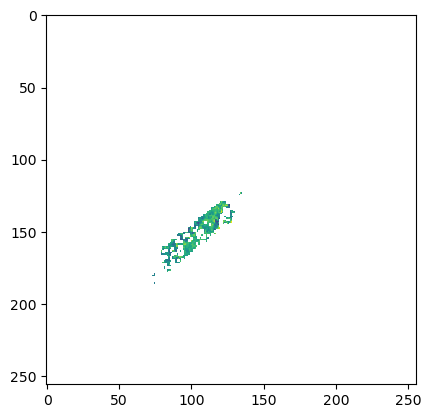

In [151]:
imshow(image)

## STAC

In [12]:
site_name = "cal001"
s3_target_zarr_dir = "s3://sdap-dev-zarr/OCO3/outputs/veda/demo-2024.10.28-target/SIMULTEST_TFP_post_qf/oco3"
site_zarr_s3url = f"{s3_target_zarr_dir}/{site_name}.zarr"
item_template = {
    "id": f"oco3-target-{site_name}",
    "type": "Feature",
    "links": [],
    #"bbox": [lon_min, lat_min, lon_max, lat_max],
    # "geometry": shapely.geometry.mapping(shapely.geometry.box(*BBOX[region])),
    "stac_version": "1.0.0",
    "properties": {"start_datetime": None, "end_datetime": None},
    "assets": {
        "zarr-s3": {
            "href": site_zarr_s3url,
            "type": "application/vnd+zarr",
            "roles": ["data", "zarr", "s3"],
            "xarray:open_kwargs": {"consolidated": True},
        }
    },
}

In [13]:
item = xstac.xarray_to_stac(
    target_ds, item_template, temporal_dimension="time", x_dimension="longitude", y_dimension="latitude"
)


In [19]:
import pprint
pprint.pprint(item.to_dict())

{'assets': {'zarr-s3': {'href': 's3://sdap-dev-zarr/OCO3/outputs/veda/demo-2024.10.28-target/SIMULTEST_TFP_post_qf/oco3//cal001.zarr',
                        'roles': ['data', 'zarr', 's3'],
                        'type': 'application/vnd+zarr',
                        'xarray:open_kwargs': {'consolidated': True}}},
 'geometry': None,
 'id': 'oco3-target-cal001',
 'links': [],
 'properties': {'cube:dimensions': {'latitude': {'axis': 'y',
                                                 'description': 'latitude',
                                                 'extent': [36.99700164794922,
                                                            39.99700164794922],
                                                 'reference_system': {'$schema': 'https://proj.org/schemas/v0.7/projjson.schema.json',
                                                                      'coordinate_system': {'axis': [{'abbreviation': 'Lat',
                                                             